# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.925586,False,-0.780106
1,0.040524,False,0.817322
2,-0.917482,False,-1.126283
3,2.527187,True,6.749634
4,0.424340,False,-0.596998
...,...,...,...
995,-0.296269,True,4.422545
996,-0.317680,False,-0.082002
997,0.369659,False,-0.533308
998,-1.376906,False,-1.448601


<AxesSubplot: xlabel='v0'>

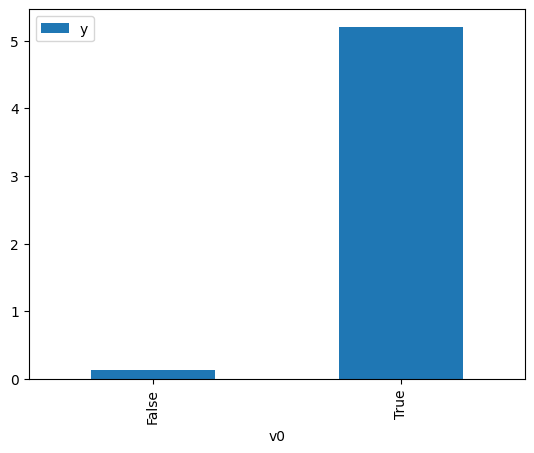

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

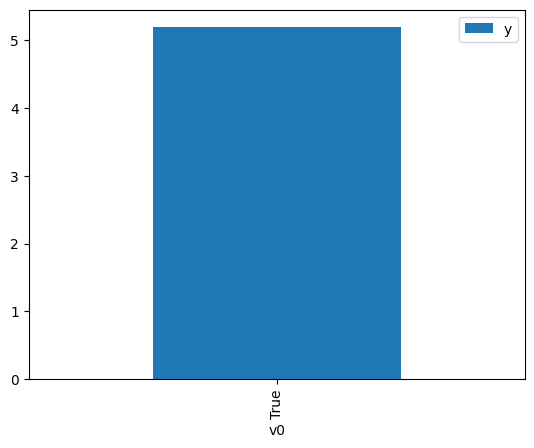

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.946810,False,0.720078,0.153818,6.501200
1,1.787287,False,2.109053,0.034085,29.338544
2,1.280898,False,1.421287,0.086545,11.554653
3,1.671965,False,2.039689,0.042318,23.630540
4,0.517289,False,1.552860,0.295830,3.380320
...,...,...,...,...,...
995,0.662590,False,1.396345,0.240374,4.160178
996,-2.239011,False,-0.499603,0.989106,1.011014
997,0.418026,False,0.925231,0.337684,2.961353
998,0.681283,False,1.154752,0.233781,4.277517


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.719787,True,7.715784,0.961305,1.040253
1,0.932860,True,6.326615,0.842608,1.186792
2,-0.954614,True,4.542720,0.118831,8.415294
3,1.721617,True,5.821451,0.961437,1.040110
4,0.094250,True,8.072083,0.510535,1.958730
...,...,...,...,...,...
995,-0.517667,True,3.079754,0.240246,4.162396
996,-1.304338,True,2.742947,0.063826,15.667619
997,-1.081362,True,2.281089,0.095285,10.494885
998,-1.534727,True,3.454180,0.041687,23.988416


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.941
Model:                            OLS   Adj. R-squared (uncentered):              0.940
Method:                 Least Squares   F-statistic:                              7901.
Date:                Fri, 11 Nov 2022   Prob (F-statistic):                        0.00
Time:                        08:52:32   Log-Likelihood:                         -1493.2
No. Observations:                1000   AIC:                                      2990.
Df Residuals:                     998   BIC:                                      3000.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8326      0.039     21.295      0.000       0.756       0.909
x2             5.0986      0.056     91.829      0.000       4.990       5.208
==============================================================================
Omnibus:                        0.296   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.863   Jarque-Bera (JB):                0.194
Skew:                          -0.006   Prob(JB):                        0.908
Kurtosis:                       3.067   Cond. No.                         2.06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""